# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

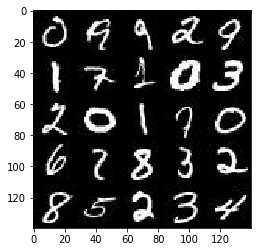

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

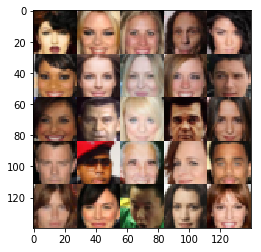

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_height,image_width,image_channels),name="input_real")
    input_z = tf.placeholder(tf.float32,(None,z_dim),name="input_z")
    learning_rate_pl =tf.placeholder(tf.float32,name="learning_rate")

    return input_real,input_z,learning_rate_pl


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.20
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flattened = tf.reshape(relu3, (-1,4*4*256))
        
        logits= tf.layers.dense(flattened,1)
        out= tf.sigmoid(logits)
    
        return out, logits


"""
 print("Shape 1 :{}",relu2)
 print("Shape :{}",relu3)      
        
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse_state = not is_train
    alpha = 0.10
    with tf.variable_scope('generator',reuse=reuse_state): 
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1,(-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256 , 4,strides = 1, padding= 'valid' )
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides= 2, padding= 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides= 2, padding= 'same')    
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z,out_channel_dim,is_train=True)
    d_model_real,d_logits_real =discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake =discriminator(gen_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
   
   
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list= g_vars)
        d_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss, var_list= d_vars)
    
        return d_opt_train, g_opt_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    losses = []
    steps = 0
    _,image_width,image_height,image_channels = data_shape
    input_real, input_z , learning_rate_pl = model_inputs(image_width,image_height,image_channels,z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss,learning_rate_pl, beta1)
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count): 
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #sample random noise for G
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                batch_images = batch_images * 2.0
                
                sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                
                
                
                if steps % 10 == 0 :
                    train_loss_d = d_loss.eval({input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess,n_images,input_z,image_channels,data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.4065... Generator Loss: 0.0077
Epoch 1/2... Discriminator Loss: 3.7758... Generator Loss: 0.0430
Epoch 1/2... Discriminator Loss: 2.7728... Generator Loss: 0.1429
Epoch 1/2... Discriminator Loss: 1.6389... Generator Loss: 0.5292
Epoch 1/2... Discriminator Loss: 2.8599... Generator Loss: 0.2077
Epoch 1/2... Discriminator Loss: 1.5863... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.9072... Generator Loss: 0.8441
Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 1.6649... Generator Loss: 0.4608
Epoch 1/2... Discriminator Loss: 1.8601... Generator Loss: 0.3487


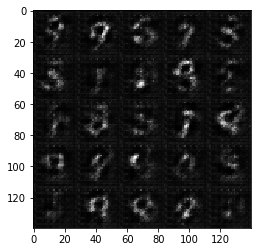

Epoch 1/2... Discriminator Loss: 1.6260... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 1.7692... Generator Loss: 0.3392
Epoch 1/2... Discriminator Loss: 1.5364... Generator Loss: 0.5323
Epoch 1/2... Discriminator Loss: 1.6388... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.7311... Generator Loss: 1.0975
Epoch 1/2... Discriminator Loss: 1.5241... Generator Loss: 0.8628
Epoch 1/2... Discriminator Loss: 1.6599... Generator Loss: 1.1825
Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 0.8270
Epoch 1/2... Discriminator Loss: 1.5088... Generator Loss: 1.2741
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.8345


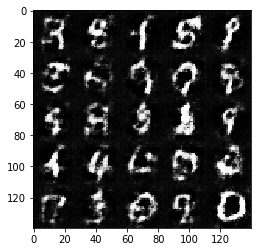

Epoch 1/2... Discriminator Loss: 1.6362... Generator Loss: 1.2195
Epoch 1/2... Discriminator Loss: 1.4976... Generator Loss: 0.7985
Epoch 1/2... Discriminator Loss: 1.5250... Generator Loss: 1.0169
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.9230
Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 0.9493
Epoch 1/2... Discriminator Loss: 1.5732... Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 1.4736... Generator Loss: 1.0013
Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.5369... Generator Loss: 1.1316
Epoch 1/2... Discriminator Loss: 1.4544... Generator Loss: 0.6348


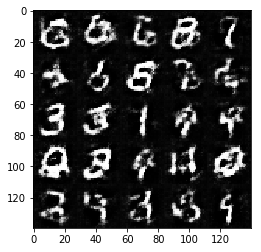

Epoch 1/2... Discriminator Loss: 1.6901... Generator Loss: 0.3341
Epoch 1/2... Discriminator Loss: 1.5932... Generator Loss: 0.4266
Epoch 1/2... Discriminator Loss: 1.5569... Generator Loss: 0.4653
Epoch 1/2... Discriminator Loss: 1.5328... Generator Loss: 0.4830
Epoch 1/2... Discriminator Loss: 1.5556... Generator Loss: 0.4225
Epoch 1/2... Discriminator Loss: 1.5133... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 1.5432... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 1.4464... Generator Loss: 0.5631
Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 0.5500
Epoch 1/2... Discriminator Loss: 1.7154... Generator Loss: 0.3529


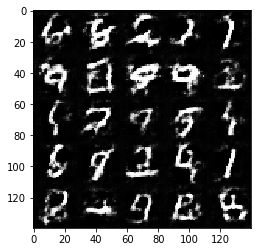

Epoch 1/2... Discriminator Loss: 1.6082... Generator Loss: 0.3895
Epoch 1/2... Discriminator Loss: 1.5757... Generator Loss: 0.4792
Epoch 1/2... Discriminator Loss: 1.5358... Generator Loss: 0.4422
Epoch 1/2... Discriminator Loss: 1.4826... Generator Loss: 0.5500
Epoch 1/2... Discriminator Loss: 1.6078... Generator Loss: 0.3931
Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 0.5074
Epoch 1/2... Discriminator Loss: 1.5455... Generator Loss: 0.4398
Epoch 1/2... Discriminator Loss: 1.5353... Generator Loss: 0.4530
Epoch 1/2... Discriminator Loss: 1.4635... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 1.5345... Generator Loss: 0.4635


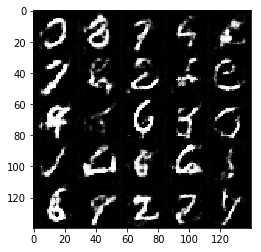

Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 0.4288
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.5949
Epoch 1/2... Discriminator Loss: 1.7585... Generator Loss: 0.2971
Epoch 1/2... Discriminator Loss: 1.4171... Generator Loss: 0.6708
Epoch 1/2... Discriminator Loss: 1.4587... Generator Loss: 1.0318
Epoch 1/2... Discriminator Loss: 1.4984... Generator Loss: 0.8594
Epoch 1/2... Discriminator Loss: 1.7362... Generator Loss: 1.1196
Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 0.6115
Epoch 1/2... Discriminator Loss: 1.7074... Generator Loss: 0.3399
Epoch 1/2... Discriminator Loss: 1.4133... Generator Loss: 0.7272


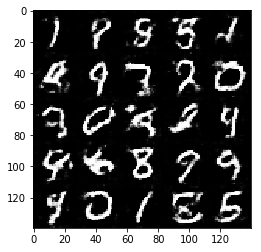

Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.6664
Epoch 1/2... Discriminator Loss: 1.5797... Generator Loss: 1.1682
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.7363
Epoch 1/2... Discriminator Loss: 1.4667... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 1.4330... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.6254
Epoch 1/2... Discriminator Loss: 1.7499... Generator Loss: 0.3102
Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 0.6961
Epoch 1/2... Discriminator Loss: 1.5892... Generator Loss: 0.4069
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.7065


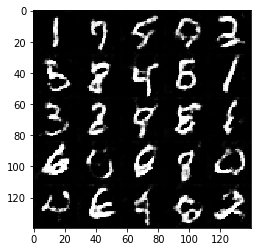

Epoch 1/2... Discriminator Loss: 1.6139... Generator Loss: 0.3916
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 0.5144
Epoch 1/2... Discriminator Loss: 1.7054... Generator Loss: 0.3336
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.5600
Epoch 1/2... Discriminator Loss: 2.0199... Generator Loss: 0.2259
Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 1.8295... Generator Loss: 1.4169
Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 0.5992


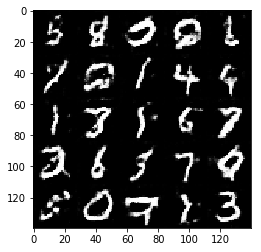

Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.6721... Generator Loss: 1.3459
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 1.6839... Generator Loss: 0.3612
Epoch 1/2... Discriminator Loss: 1.4569... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 1.5003... Generator Loss: 0.4796
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.6368
Epoch 1/2... Discriminator Loss: 1.7760... Generator Loss: 1.5166
Epoch 1/2... Discriminator Loss: 1.4940... Generator Loss: 0.7647


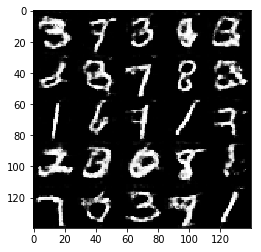

Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 0.5479
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.7155
Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 0.4108
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.5717
Epoch 2/2... Discriminator Loss: 1.6358... Generator Loss: 0.4125
Epoch 2/2... Discriminator Loss: 1.4836... Generator Loss: 0.4856
Epoch 2/2... Discriminator Loss: 1.6246... Generator Loss: 0.3753
Epoch 2/2... Discriminator Loss: 1.3878... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 1.1045
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.8101


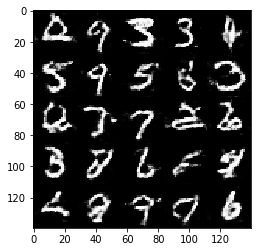

Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 0.5435
Epoch 2/2... Discriminator Loss: 1.6135... Generator Loss: 0.4338
Epoch 2/2... Discriminator Loss: 1.3686... Generator Loss: 0.7397
Epoch 2/2... Discriminator Loss: 1.4130... Generator Loss: 1.0340
Epoch 2/2... Discriminator Loss: 1.4641... Generator Loss: 0.9197
Epoch 2/2... Discriminator Loss: 1.5239... Generator Loss: 1.1123
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 1.0165
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 1.0406
Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.6800
Epoch 2/2... Discriminator Loss: 1.7162... Generator Loss: 0.3272


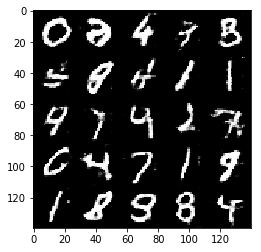

Epoch 2/2... Discriminator Loss: 1.4331... Generator Loss: 0.8468
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 1.0549
Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 1.4464... Generator Loss: 1.0124
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 1.0924
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.8683
Epoch 2/2... Discriminator Loss: 1.4007... Generator Loss: 1.1392
Epoch 2/2... Discriminator Loss: 1.3232... Generator Loss: 0.7818
Epoch 2/2... Discriminator Loss: 1.4524... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 1.8424... Generator Loss: 0.2751


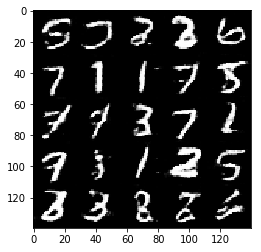

Epoch 2/2... Discriminator Loss: 1.3283... Generator Loss: 0.6307
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.5159
Epoch 2/2... Discriminator Loss: 1.4337... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 1.2630
Epoch 2/2... Discriminator Loss: 1.4404... Generator Loss: 1.0452
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.6907
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 0.4814
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.5679
Epoch 2/2... Discriminator Loss: 1.7378... Generator Loss: 0.3178
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.5775


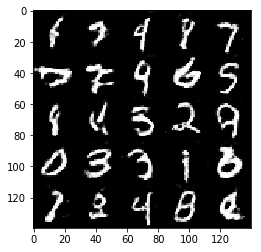

Epoch 2/2... Discriminator Loss: 1.6670... Generator Loss: 0.3648
Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 1.3057... Generator Loss: 0.9513
Epoch 2/2... Discriminator Loss: 1.4889... Generator Loss: 0.5961
Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 0.6482
Epoch 2/2... Discriminator Loss: 1.4206... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.8759
Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 1.0287
Epoch 2/2... Discriminator Loss: 1.3374... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 1.5133... Generator Loss: 0.4130


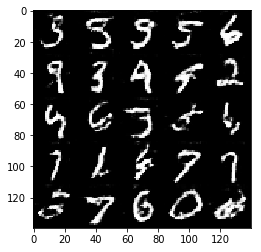

Epoch 2/2... Discriminator Loss: 1.5117... Generator Loss: 0.4938
Epoch 2/2... Discriminator Loss: 1.4088... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.6210
Epoch 2/2... Discriminator Loss: 1.5009... Generator Loss: 0.4459
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.6120
Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.5924
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 1.6127... Generator Loss: 0.3855
Epoch 2/2... Discriminator Loss: 1.5809... Generator Loss: 0.3867
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.6488


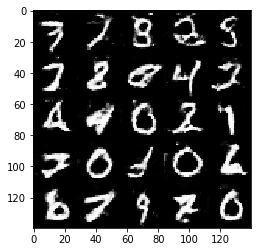

Epoch 2/2... Discriminator Loss: 1.5756... Generator Loss: 1.3873
Epoch 2/2... Discriminator Loss: 1.5128... Generator Loss: 0.4518
Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 0.5999
Epoch 2/2... Discriminator Loss: 1.5130... Generator Loss: 0.4314
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 0.4923
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 1.5572... Generator Loss: 0.4211
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 1.3693... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 0.5549


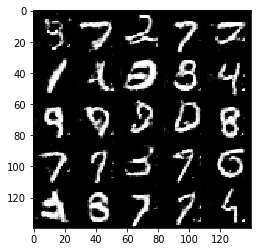

Epoch 2/2... Discriminator Loss: 1.8688... Generator Loss: 0.2655
Epoch 2/2... Discriminator Loss: 1.5266... Generator Loss: 0.4289
Epoch 2/2... Discriminator Loss: 1.7766... Generator Loss: 0.3106
Epoch 2/2... Discriminator Loss: 1.4860... Generator Loss: 0.4840
Epoch 2/2... Discriminator Loss: 1.8730... Generator Loss: 0.2603
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 1.1346
Epoch 2/2... Discriminator Loss: 1.8152... Generator Loss: 0.2845
Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.7482
Epoch 2/2... Discriminator Loss: 1.7052... Generator Loss: 1.2203


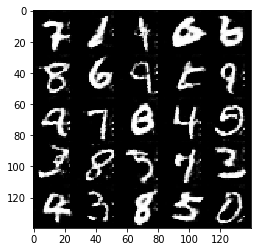

Epoch 2/2... Discriminator Loss: 1.4383... Generator Loss: 0.4772
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.7560
Epoch 2/2... Discriminator Loss: 1.4922... Generator Loss: 0.4700
Epoch 2/2... Discriminator Loss: 1.8323... Generator Loss: 1.5022
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.5856
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.5829
Epoch 2/2... Discriminator Loss: 1.4164... Generator Loss: 0.5347
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 1.3326... Generator Loss: 1.2376


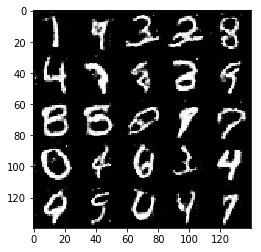

Epoch 2/2... Discriminator Loss: 1.4491... Generator Loss: 0.4743
Epoch 2/2... Discriminator Loss: 1.5951... Generator Loss: 0.3900
Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 0.5621
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.5253
Epoch 2/2... Discriminator Loss: 1.3248... Generator Loss: 0.6956
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 1.1883
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.8317


In [17]:
batch_size = 64
z_dim = 130
learning_rate = 0.0005
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.7868... Generator Loss: 2.4867
Epoch 1/1... Discriminator Loss: 2.1200... Generator Loss: 3.9910
Epoch 1/1... Discriminator Loss: 1.7142... Generator Loss: 2.0572
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 2.2774... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.9728... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 2.0482... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.7660... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.9967... Generator Loss: 0.4514


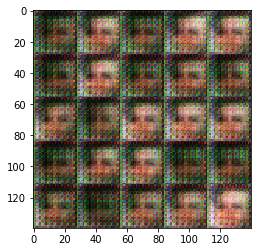

Epoch 1/1... Discriminator Loss: 1.7634... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.5918... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.8431... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.9010... Generator Loss: 0.4767
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.6627


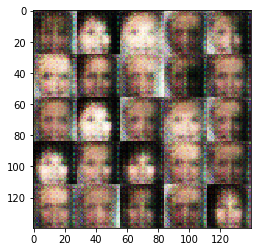

Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.7031


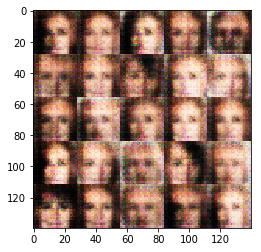

Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7887


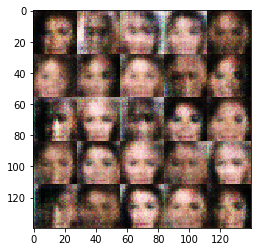

Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.6394


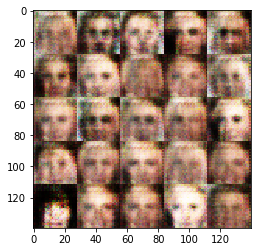

Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7146


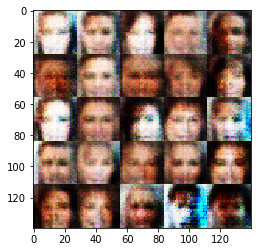

Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8121


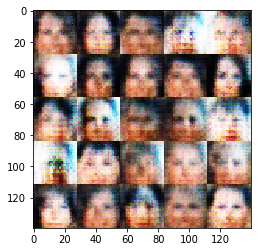

Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7856


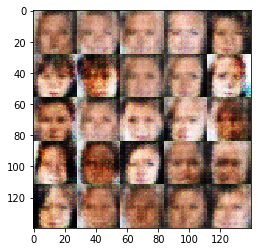

Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7527


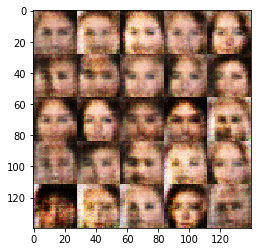

Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.8064


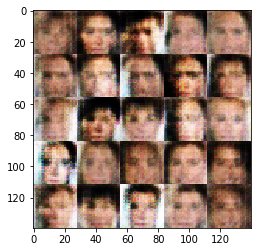

Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7764


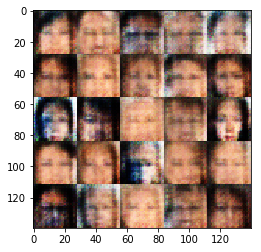

Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7631


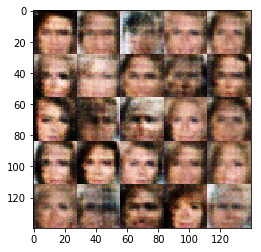

Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7723


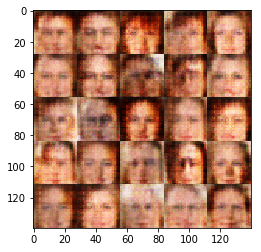

Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7095


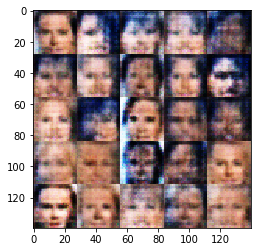

Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6778


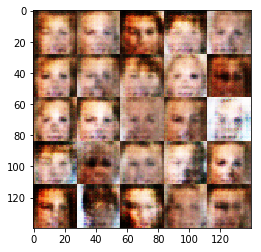

Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7677


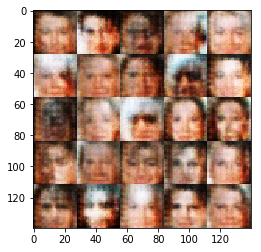

Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7025


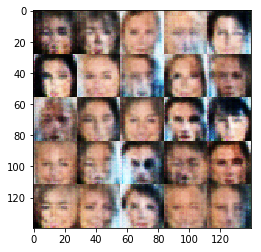

Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6239


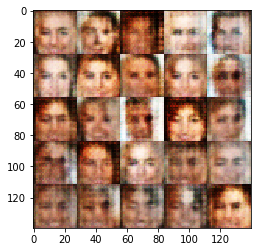

Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.8315


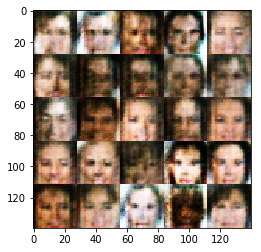

Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7909


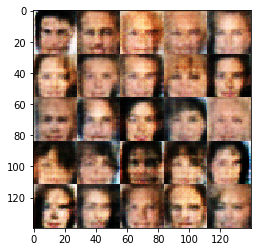

Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8093


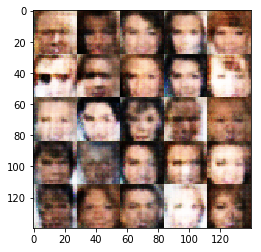

Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7815


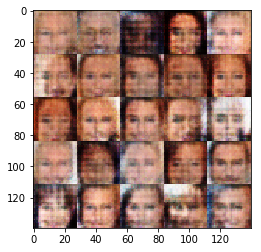

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8942


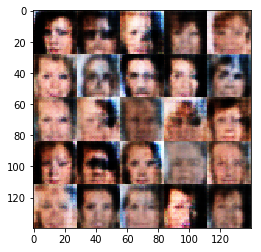

Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8039


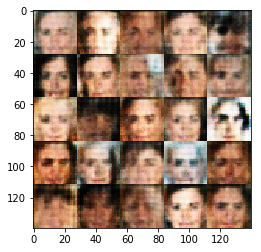

Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8314


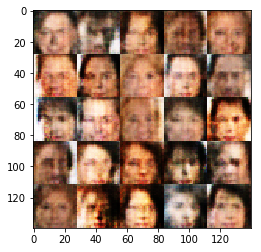

Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7765


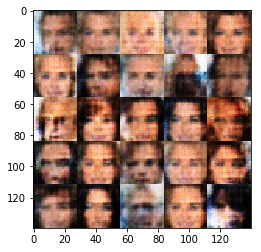

Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8590


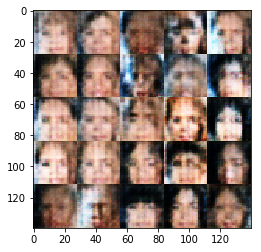

Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7544


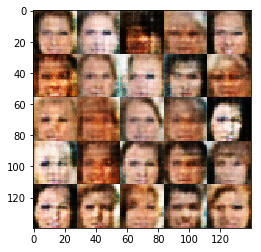

Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6948


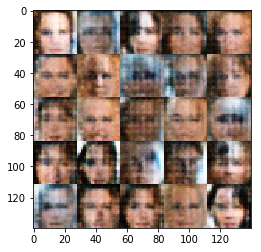

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7673


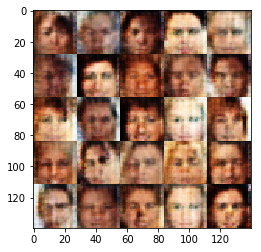

Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6925


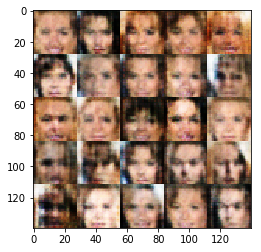

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7011


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.00045
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.